In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

In [2]:
dir_plots = './plots/'
dir_file = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'

all_files = glob(f"{dir_file}*.dta")
easy_files = glob(f"{rel_data_dir_easy}*.dta")

df_easy = pd.read_stata(easy_files[0])
df_easy = df_easy[df_easy['wave'] == 8]
df_acc_hr = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_gv_accelerometer_hour.dta'))
df_acc_hr.drop(df_acc_hr.loc[df_acc_hr['GGIR_N_valid_hours'] < 0.75].index, inplace=True)
df_acc_hr.drop(df_acc_hr.loc[df_acc_hr['measurementday'] > 7].index, inplace=True)
df_ph = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_ph.dta'))
df_br = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_br.dta'))


In [3]:
df1 = df_acc_hr[["mergeid", "measurementday", "weekday", "GGIR_mean_ENMO_hour", "hour", "OxCGRT_stay_at_home", "OxCGRT_stringency_index"]].copy()
df2 = df_ph[["mergeid", 'ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3']].copy()
df3 = df_br[["mergeid", 'br015_', 'br016_']].copy()
df4 = df_easy[["mergeid", "female", "age", "bmi"]].copy()

In [4]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [5]:
df = df1.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df2[get_common_columns(df2, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df3[get_common_columns(df3, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df4[get_common_columns(df4, df)], right_on=['mergeid'], how='left')

In [6]:
def map_selected_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -1,
            1:1,
            0:0,
            -1:-1,
        })
    return df
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_bmi_num(df)
df.drop(df.loc[df['bmi'] < 15].index, inplace=True)

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_freq_num(df, ['br015_', 'br016_']) 

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)


In [7]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [8]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d5'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d6'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['d7'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)

In [9]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])

thresholds: https://doi.org/10.1371/journal.pone.0164045.s002

light-intensity physical activities (e.g. standing and light walking, household activities)


In [10]:
sed_t = 6 #mean = 3.6
LPA_t = 100 #mean household = 5.9-22.4; mean = 58.5 (self-paced-free-living walk)

conditions = [
    (df["GGIR_mean_ENMO_hour"] <= sed_t),
    (df["GGIR_mean_ENMO_hour"] > sed_t) & (df["GGIR_mean_ENMO_hour"] <= LPA_t),
    (df["GGIR_mean_ENMO_hour"] > LPA_t)
]

behaviour = ["SED", "LPA", "MVPA"]
#behaviour = [1,2,3,4]
df["behaviour"] = np.select(conditions, behaviour)
df["behaviour"].fillna(0)

#count occurrence 
counts = df.groupby('disease').behaviour.value_counts().unstack().astype(str)
#count occurrence of each value in 'behaviour' column per disease-group as percentage of total 
percs = df.groupby('disease').behaviour.value_counts(normalize=True).mul(100).round(1).unstack().astype(str)

total_ENMO = df.groupby('disease')['GGIR_mean_ENMO_hour'].agg(['mean']) 
beh_group = pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])
beh_group = pd.merge(left=total_ENMO, left_on='disease', right=beh_group, right_on='disease')
#beh_group.to_excel("behaviour.xlsx", index = True, float_format="%.2f")
beh_group.head()

C:\Users\mjbur\AppData\Local\Temp\ipykernel_9948\278627096.py:22: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  beh_group = pd.merge(left=total_ENMO, left_on='disease', right=beh_group, right_on='disease')


,mean,"(count, LPA)","(count, MVPA)","(count, SED)","(percentage, LPA)","(percentage, MVPA)","(percentage, SED)"
disease,,,,,,,
control,28.903813,42709,2489,13779,72.4,4.2,23.4
d1,27.251352,26945,1353,8995,72.3,3.6,24.1
d2,31.168574,4869,469,1647,69.7,6.7,23.6
d3,27.581928,5575,222,1655,74.8,3.0,22.2
d4,25.027913,6939,385,2860,68.1,3.8,28.1


In [11]:
'''
WHO recommendation:
150 min in MPA per week or, ~ MPA count = 3 (180 min)
75 min VPA per week , ~ VPA count = 1 (60 min)
'''

resp_be = (
    df.groupby(['mergeid', 'disease'])
.behaviour
.value_counts()
.unstack()
)

resp_be["WHO_recom"] = np.where(resp_be['MVPA'] == 3, int(1), int(0))
resp_be.head()


,behaviour,LPA,MVPA,SED,WHO_recom
mergeid,disease,,,,
Bf-031257-01,control,109.0,NaN,54.0,0
Bf-043946-02,d1,96.0,NaN,63.0,0
Bf-073169-01,d1,120.0,3.0,45.0,1
Bf-227520-04,d1,33.0,NaN,15.0,0
Bf-286437-02,d1,104.0,NaN,16.0,0


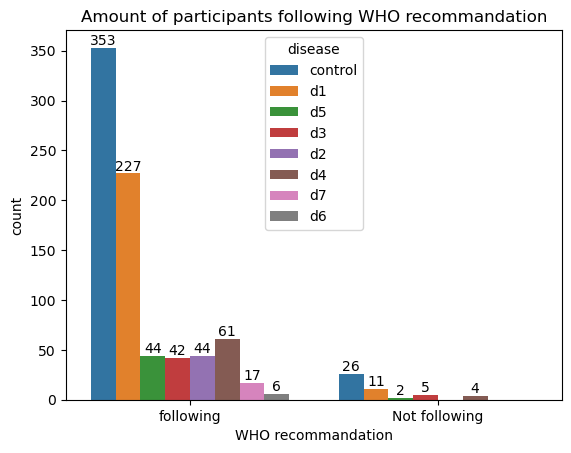

In [12]:
plt.figure()
ax = sns.countplot(data=resp_be, x="WHO_recom", hue=resp_be.index.get_level_values(1))
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels(["following", "Not following"])
ax.set_xlabel("WHO recommandation")
plt.title("Amount of participants following WHO recommandation")
plt.savefig(f'{dir_plots} WHO recommandation (bar)')